In [1]:
from PIGNN_Model_v1 import *
from prepare_data import *

In [2]:
import scipy.spatial

In [3]:
plt.style.use('ggplot')

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model = PIGNN_Euler(device=device).to(device)

In [5]:
data_dir = "../Data/Inc_Inviscid_Hydrofoil"
mesh_filename = "mesh_NACA0012_5deg_6814.su2"

mesh, _ = load_mesh(data_dir, mesh_filename)

Warning: meshio does not support tags of string type.
    Surface tag  airfoil will be replaced by 1

Warning: meshio does not support tags of string type.
    Surface tag  lower_wall will be replaced by 2

Warning: meshio does not support tags of string type.
    Surface tag  inlet will be replaced by 3

Warning: meshio does not support tags of string type.
    Surface tag  outlet will be replaced by 4

Warning: meshio does not support tags of string type.
    Surface tag  upper_wall will be replaced by 5

In [6]:
n_vol_samples = 2*len(mesh.points)
print(n_vol_samples)

x_vol = sample_points(mesh.cells[0].data, mesh.points, n_vol_samples)
node_type_ids = [np.zeros(n_vol_samples, dtype=np.int32)]
node_su2_tags = [np.zeros(n_vol_samples, dtype=np.int32)]

x_bc = []

for su2_tag in np.unique(mesh.cell_data["su2:tag"][1]):
    cells = mesh.cells[1].data[mesh.cell_data["su2:tag"][1] == su2_tag]
    print(su2_tag, len(cells))

    n_bc_samples = 2*len(cells)
    x_bc_i = sample_points(cells, mesh.points, n_bc_samples)
    x_bc.append(x_bc_i)
    node_type_ids.append(np.ones(n_bc_samples, dtype=np.int32)*su2_to_node_type[su2_tag])
    node_su2_tags.append(np.ones(n_bc_samples, dtype=np.int32)*su2_tag)

hull = scipy.spatial.ConvexHull(mesh.points)
x_hull = mesh.points[hull.vertices]
node_type_ids.append(np.ones(len(x_hull), dtype=np.int32)*node_types["bbox"])
node_su2_tags.append(np.ones(len(x_hull), dtype=np.int32)*6)

x_bc = np.concatenate(x_bc)
x0 = np.concatenate((x_vol, x_bc, x_hull))
node_type_ids = np.concatenate(node_type_ids)
node_su2_tags = np.concatenate(node_su2_tags)

x_vol.shape, x_bc.shape, x0.shape, x_hull.shape, node_type_ids.shape, node_su2_tags.shape

7118
1 128
2 49
3 39
4 39
5 49


((7118, 2), (608, 2), (7730, 2), (4, 2), (7730,), (7730,))

In [7]:
#### moved: create_multilevel_graph --> prepare_data.py

# def create_multilevel_graph(x0, node_type_ids, node_su2_tags, num_levels=8):

#     # num_levels = 8

#     node_subsampling_prob = np.empty_like(x0[:,0], dtype=np.float32)

#     # volume
#     node_subsampling_prob[node_su2_tags == 0] = 0.5

#     # airfoil
#     node_subsampling_prob[node_su2_tags == 1] = 0.75

#     # lower_wall
#     node_subsampling_prob[node_su2_tags == 2] = 0.75

#     # inlet 
#     node_subsampling_prob[node_su2_tags == 3] = 0.75

#     # outlet 
#     node_subsampling_prob[node_su2_tags == 4] = 0.75

#     # upper_wall 
#     node_subsampling_prob[node_su2_tags == 5] = 0.75

#     # bbox
#     node_subsampling_prob[node_su2_tags == 6] = 1

#     node_new_ids = np.arange(len(node_type_ids))
#     nodes_last_lvl = node_new_ids
#     node_orig_ids = node_new_ids
#     node_lvls = np.zeros_like(node_new_ids)
#     node_pts = x0
#     tris = []

#     tri = Delaunay(node_pts)
#     tris.append(tri)

#     cells = tri.simplices

#     edges = []
#     indptr, indices = tri.vertex_neighbor_vertices
#     for k in range(len(indptr)-1):
#         i = indptr[k]
#         j = indptr[k+1]
#         for m in indices[i:j]:
#             edge = np.array([[node_new_ids[k], node_new_ids[m]]])
#             edges.append(edge)

#     print(0, len(node_new_ids), len(node_new_ids), len(edges))

#     for lvl in range(1, num_levels):
#         p = np.random.rand(len(nodes_last_lvl))
#         # nodes_lvl = [n for i,n in enumerate(nodes_last_lvl) if node_subsampling_prob[n] >= p[i]]
#         nodes_lvl_sampled = nodes_last_lvl[node_subsampling_prob[nodes_last_lvl] >= p]    
#         node_orig_ids = np.concatenate((node_orig_ids, nodes_lvl_sampled))

#         nodes_new_lvl = np.arange(nodes_lvl_sampled.shape[0], dtype=node_new_ids.dtype) + node_new_ids.shape[0]
#         node_new_ids = np.concatenate((node_new_ids, nodes_new_lvl))

#         np.stack((nodes_lvl_sampled, nodes_new_lvl), axis=1).shape
#         edges.append(np.stack((nodes_lvl_sampled, nodes_new_lvl), axis=1))
#         edges.append(np.stack((nodes_new_lvl, nodes_lvl_sampled), axis=1))

#         # node_subsampling_prob_new = node_subsampling_prob[nodes_lvl]
#         node_subsampling_prob = np.concatenate((node_subsampling_prob, node_subsampling_prob[nodes_lvl_sampled]))

#         node_lvls_new = np.ones_like(nodes_new_lvl) * lvl
#         # node_lvls_new = lvl
#         node_lvls = np.concatenate((node_lvls, node_lvls_new))

#         node_pts_lvl = node_pts[nodes_lvl_sampled]
#         node_pts = np.concatenate((node_pts, node_pts_lvl))

#         node_new_type_ids = node_type_ids[nodes_lvl_sampled]
#         node_type_ids = np.concatenate((node_type_ids, node_new_type_ids))
#         node_su2_tags = np.concatenate((node_su2_tags, node_su2_tags[nodes_lvl_sampled]))

#         tri = Delaunay(node_pts_lvl)
#         tris.append(tri)

#         cells = np.concatenate((cells, tri.simplices + nodes_new_lvl.min()))

#         indptr, indices = tri.vertex_neighbor_vertices
#         for k in range(len(indptr)-1):
#             i = indptr[k]
#             j = indptr[k+1]
#             for m in indices[i:j]:
#                 edge = np.array([[nodes_new_lvl[k], nodes_new_lvl[m]]])
#                 edges.append(edge)

#         print(lvl, len(nodes_lvl_sampled), len(node_new_ids), len(edges))

#         nodes_last_lvl = nodes_new_lvl

#     # edges = np.array(edges)

#     return node_pts, node_orig_ids, node_new_ids, node_type_ids, node_lvls, edges, node_subsampling_prob, tris, cells

node_pts, node_orig_ids, node_new_ids, node_type_ids, node_lvls, node_su2_tags, edges, node_subsampling_prob, tris, cells = create_multilevel_graph(x0, node_type_ids, node_su2_tags, num_levels=8)
    


0 7730 7730 45662
1 3982 11712 69002
2 2132 13844 81374
3 1160 15004 88028
4 653 15657 91714
5 378 16035 93800
6 224 16259 95014
7 147 16406 95808


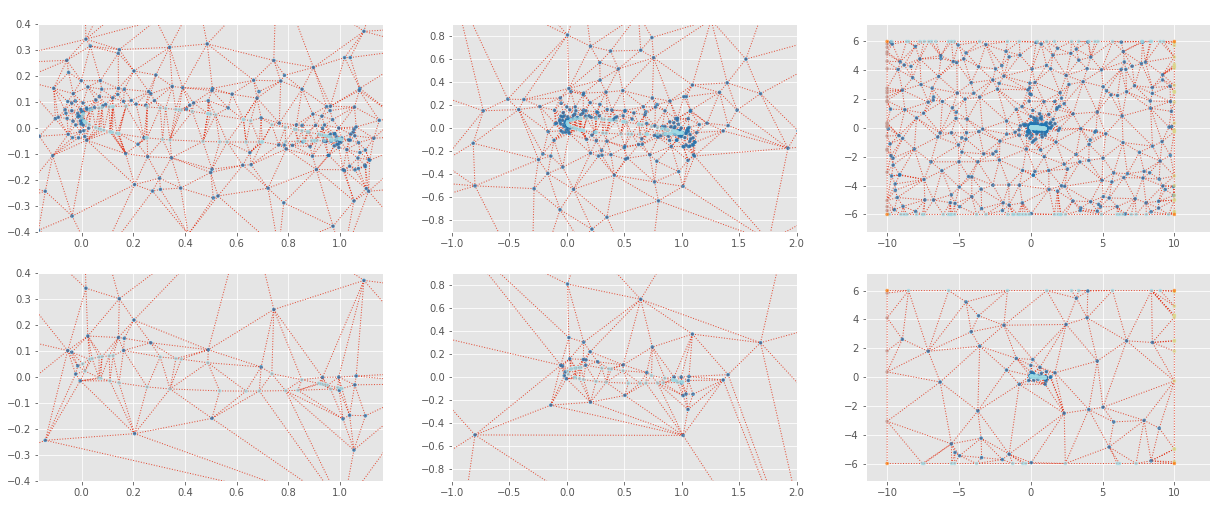

In [8]:
# lvls = [0, 1, 2, 4, 7]
zooms = [18, 8, 1]

lvls = [4, 7]



fig_width = 0.7 * 10
fig_height = 0.7 * 6
center = [0.5, 0.]
data_max = [10, 6]
data_min = [-10, -6]
data_width = 20
data_hwidth = 12


fig, axes = plt.subplots(len(lvls), len(zooms), figsize=(fig_width*len(zooms), fig_height*len(lvls)))

for i, lvl in enumerate(lvls):
    for j, zoom in enumerate(zooms):
        
        nodes_lvl = np.where(np.array(node_lvls) == lvl)[0]
        # tri = Delaunay(node_pts[nodes_lvl])
        tri = tris[lvl]

        xmin = center[0] - data_hwidth/zoom
        xmax = center[0] + data_hwidth/zoom
        ymin = center[1] - data_hwidth/zoom*fig_height/fig_width
        ymax = center[1] + data_hwidth/zoom*fig_height/fig_width

        # axes[i,j].plot(node_pts[airfoil_node_indices][: ,0], node_pts[airfoil_node_indices][: ,1], linestyle="-", alpha=0.2)
        axes[i,j].triplot(node_pts[nodes_lvl,0], node_pts[nodes_lvl,1], tri.simplices, lw=1, linestyle=":")
        # axes[i,j].scatter(node_pts[nodes_lvl,0], node_pts[nodes_lvl,1], marker=".", c=node_su2_tags[nodes_lvl], cmap="tab20", alpha=0.7)
        axes[i,j].scatter(node_pts[nodes_lvl,0], node_pts[nodes_lvl,1], marker=".", c=node_type_ids[nodes_lvl], cmap="tab20", alpha=0.7)

        # axes[i,j].scatter(node_pts[nodes_lvl,0], node_pts[nodes_lvl,1], marker=".", c=node_subsampling_prob[nodes_lvl])
        # axes[i,j].legend()


        # plt.scatter(node_pts[airfoil_edge_node_indices,0], node_pts[airfoil_edge_node_indices,1], marker="X", c=node_type_ids[airfoil_edge_node_indices], cmap="tab10")
        # plt.scatter(mesh.points[test_nodes,0], mesh.points[test_nodes,1], marker=".", c="blue")
        # airfoil = np.where(su2_tag == 1)[0]
        # print(airfoil)

        # plt.xlim([-2., 3.])
        # plt.ylim([-1, 1])

        axes[i,j].set_xlim([xmin, xmax])
        axes[i,j].set_ylim([ymin, ymax])

        axes[i,j].set_title("Level {} - Zoom {}".format(lvl, zoom))

# plt.savefig("multilevelgraph.svg")

In [9]:
# fig.savefig("multilevelgraph.svg")
# fig.savefig("multilevelgraph.jpg", dpi=600)

/tmp/ipykernel_22687/953659361.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


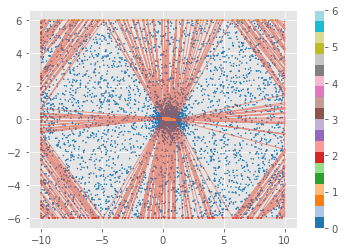

In [11]:
d = scipy.spatial.Delaunay(x0)
d_bc = scipy.spatial.Delaunay(x_bc)

nodes_lvl = np.where(np.array(node_lvls) == 0)[0]

sc = plt.scatter(x0[: ,0], x0[: ,1], s=1, c=node_su2_tags[nodes_lvl], cmap="tab20")
# plt.scatter(x_bc_samples[: ,0], x_bc_samples[: ,1], s=1, c="orange")
plt.colorbar(sc)

# plt.triplot(x0[: ,0], x0[: ,1], d.simplices, lw=1, linestyle="-", alpha=0.35)
# plt.legend()
plt.triplot(x_bc[: ,0], x_bc[: ,1], d_bc.simplices, lw=1, linestyle="-", alpha=0.5)

# plt.gca().set(xlim=[-0.05, 1.05], ylim=[-0.2, 0.2])

In [ ]:
d_bc.simplices.shape

(862, 3)

In [1]:
2*3*4 # "bla"

24